## Similarity computation using encoder-decoder (pytorch)

## Mounting drive files

In [1]:
from google.colab import drive

drive.mount('MyDrive/')

Mounted at MyDrive/


## Importing libraries

In [2]:
import torch
from PIL import Image
import os
from tqdm import tqdm
from torch.utils.data import Dataset

import torchvision.transforms as T
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

## Class to read datasets

In [3]:
class FolderDataset(Dataset):
    def __init__(self, main_dir, transform=None):
        self.main_dir = main_dir
        self.transform = transform
        self.all_imgs = sorted(os.listdir(main_dir))

    def __len__(self):
        return len(self.all_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.all_imgs[idx])
        image = Image.open(img_loc).convert("RGB")

        if self.transform is not None:
            tensor_image = self.transform(image)

        return tensor_image, tensor_image

## ConvEncoder & ConvDecoder Classes

We can change this for different models (i. e., efficientNet)

In [4]:
class ConvEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.img_size = img_size
        self.conv1 = nn.Conv2d(3, 16, (3, 3), padding=(1, 1))
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d((2, 2))

        self.conv2 = nn.Conv2d(16, 32, (3, 3), padding=(1, 1))
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d((2, 2))

        self.conv3 = nn.Conv2d(32, 64, (3, 3), padding=(1, 1))
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d((2, 2))

    def forward(self, x):
        # Downscale the image with conv maxpool etc.
        # print(x.shape)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)

        # print(x.shape)

        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        # print(x.shape)

        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)

        # print(x.shape)
        return x


class ConvDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.deconv1 = nn.ConvTranspose2d(64, 32, (2, 2), stride=(2, 2))
        # self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(32, 16, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(16, 3, (2, 2), stride=(2, 2))
#         self.upsamp1 = nn.UpsamplingBilinear2d(2)
        self.relu3 = nn.ReLU(inplace=True)

    def forward(self, x):
        # print(x.shape)
        x = self.deconv1(x)
        x = self.relu1(x)
        # print(x.shape)

        x = self.deconv2(x)
        x = self.relu2(x)
        # print(x.shape)

        x = self.deconv3(x)
        x = self.relu3(x)
        # print(x.shape)
        return x

## Hyperparameters

In [5]:
IMG_VAL_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/encoder_dataset/val"
IMG_TRAIN_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/encoder_dataset/train"
IMG_SIM_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/bultos_tiendas_74/"
IMG_HEIGHT = 512 
IMG_WIDTH = 512  

SEED = 42
TRAIN_RATIO = 0.75
VAL_RATIO = 1 - TRAIN_RATIO
SHUFFLE_BUFFER_SIZE = 100

LEARNING_RATE = 1e-3
EPOCHS = 200
TRAIN_BATCH_SIZE = 32 
TEST_BATCH_SIZE = 32 
FULL_BATCH_SIZE = 32

AUTOENCODER_MODEL_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/models/baseline_autoencoder.pt"
ENCODER_MODEL_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/models/baseline_encoder.pt"
DECODER_MODEL_PATH = "/content/MyDrive/MyDrive/SPOT/package_similarities/models/baseline_decoder.pt"
EMBEDDING_SHAPE = (1, 64, 64, 64)


## Setting training and validation steps

In [6]:
__all__ = ["train_step", "val_step", "create_embedding"]

import torch
import torch.nn as nn

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def train_step(encoder, decoder, train_loader, loss_fn, optimizer, device):
    # device = "cuda"
    encoder.train()
    decoder.train()

    # print(device)

    for batch_idx, (train_img, target_img) in enumerate(train_loader):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()

        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = loss_fn(dec_output, target_img)
        loss.backward()

        optimizer.step()

    return loss.item()


def val_step(encoder, decoder, val_loader, loss_fn, device):
    encoder.eval()
    decoder.eval()

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(val_loader):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            loss = loss_fn(dec_output, target_img)

    return loss.item()

## Dataset creation and loaders

We can add here data augmentation to enhace accuracy (!!!!)

In [7]:
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# print("Setting Seed for the run, seed = {}".format(config.SEED))

# seed_everything(config.SEED)

transforms_val = T.Compose([T.Resize((IMG_WIDTH,IMG_HEIGHT)),T.ToTensor()])
transforms_train = T.Compose([T.Resize((IMG_WIDTH,IMG_HEIGHT)),T.AutoAugment(T.AutoAugmentPolicy.SVHN),T.ToTensor()])

print("------------ Creating Dataset ------------")
train_dataset = FolderDataset(IMG_TRAIN_PATH, transforms_train)
val_dataset = FolderDataset(IMG_VAL_PATH, transforms_val)
sim_dataset = FolderDataset(IMG_SIM_PATH, transforms_val)

# train_size = int(TRAIN_RATIO * len(full_dataset))
# val_size = len(full_dataset) - train_size

# train_dataset, val_dataset = torch.utils.data.random_split(
#     full_dataset, [train_size, val_size]
# )

print("------------ Dataset Created ------------")
print("------------ Creating DataLoader ------------")
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True, drop_last=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=TEST_BATCH_SIZE
)

# full_loader = torch.utils.data.DataLoader(
#     full_dataset, batch_size=FULL_BATCH_SIZE
# )

test_loader = torch.utils.data.DataLoader(
    sim_dataset, batch_size=FULL_BATCH_SIZE
)

for batch_idx, (train_img, target_img) in enumerate(val_loader):
  print(train_img.shape)
  break

------------ Creating Dataset ------------
------------ Dataset Created ------------
------------ Creating DataLoader ------------
torch.Size([32, 3, 512, 512])


## Training

In [8]:
print("------------ Dataloader Cretead ------------")

# print(train_loader)
loss_fn = nn.MSELoss()

encoder = ConvEncoder()
decoder = ConvDecoder()

if torch.cuda.is_available():
    print("GPU Availaible moving models to GPU")
else:
    print("Moving models to CPU")

encoder.to(device)
decoder.to(device)

# print(device)

autoencoder_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.AdamW(autoencoder_params, lr=LEARNING_RATE)

# early_stopper = utils.EarlyStopping(patience=5, verbose=True, path=)
max_loss = 9999

print("------------ Training started ------------")

for epoch in tqdm(range(EPOCHS)):
    train_loss = train_step(
        encoder, decoder, train_loader, loss_fn, optimizer, device=device
    )
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")
    val_loss = val_step(
        encoder, decoder, val_loader, loss_fn, device=device
    )

    # Simple Best Model saving
    if val_loss < max_loss:
        print("Validation Loss decreased, saving new best model")
        torch.save(encoder.state_dict(), ENCODER_MODEL_PATH)
        torch.save(decoder.state_dict(), DECODER_MODEL_PATH)

    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

print("Training Done")

------------ Dataloader Cretead ------------
GPU Availaible moving models to GPU
------------ Training started ------------


  0%|          | 0/200 [00:00<?, ?it/s]

Epochs = 0, Training Loss : 0.24978363513946533


  0%|          | 1/200 [00:15<51:23, 15.49s/it]

Validation Loss decreased, saving new best model
Epochs = 0, Validation Loss : 0.18863078951835632
Epochs = 1, Training Loss : 0.1937265843153


  1%|          | 2/200 [00:18<26:39,  8.08s/it]

Validation Loss decreased, saving new best model
Epochs = 1, Validation Loss : 0.18359650671482086
Epochs = 2, Training Loss : 0.2133341282606125


  2%|▏         | 3/200 [00:21<18:42,  5.70s/it]

Validation Loss decreased, saving new best model
Epochs = 2, Validation Loss : 0.17296868562698364
Epochs = 3, Training Loss : 0.15786373615264893


  2%|▏         | 4/200 [00:24<14:59,  4.59s/it]

Validation Loss decreased, saving new best model
Epochs = 3, Validation Loss : 0.14508609473705292
Epochs = 4, Training Loss : 0.16482961177825928


  2%|▎         | 5/200 [00:27<12:58,  3.99s/it]

Validation Loss decreased, saving new best model
Epochs = 4, Validation Loss : 0.11905388534069061
Epochs = 5, Training Loss : 0.11530637741088867


  3%|▎         | 6/200 [00:29<11:39,  3.60s/it]

Validation Loss decreased, saving new best model
Epochs = 5, Validation Loss : 0.09921536594629288
Epochs = 6, Training Loss : 0.10323037952184677


  4%|▎         | 7/200 [00:32<10:47,  3.36s/it]

Validation Loss decreased, saving new best model
Epochs = 6, Validation Loss : 0.0863071009516716
Epochs = 7, Training Loss : 0.08970053493976593


  4%|▍         | 8/200 [00:35<10:11,  3.18s/it]

Validation Loss decreased, saving new best model
Epochs = 7, Validation Loss : 0.07620172202587128
Epochs = 8, Training Loss : 0.07631465792655945


  4%|▍         | 9/200 [00:38<09:50,  3.09s/it]

Validation Loss decreased, saving new best model
Epochs = 8, Validation Loss : 0.06798642873764038
Epochs = 9, Training Loss : 0.079209104180336


  5%|▌         | 10/200 [00:41<09:32,  3.01s/it]

Validation Loss decreased, saving new best model
Epochs = 9, Validation Loss : 0.06368722021579742
Epochs = 10, Training Loss : 0.07167192548513412


  6%|▌         | 11/200 [00:44<09:22,  2.97s/it]

Validation Loss decreased, saving new best model
Epochs = 10, Validation Loss : 0.06003725156188011
Epochs = 11, Training Loss : 0.07017984986305237


  6%|▌         | 12/200 [00:47<09:13,  2.94s/it]

Validation Loss decreased, saving new best model
Epochs = 11, Validation Loss : 0.05590701103210449
Epochs = 12, Training Loss : 0.05538397282361984


  6%|▋         | 13/200 [00:49<09:06,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 12, Validation Loss : 0.05256733298301697
Epochs = 13, Training Loss : 0.05870042368769646


  7%|▋         | 14/200 [00:52<08:59,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 13, Validation Loss : 0.050863053649663925
Epochs = 14, Training Loss : 0.05775108188390732


  8%|▊         | 15/200 [00:55<08:55,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 14, Validation Loss : 0.04951254650950432
Epochs = 15, Training Loss : 0.05058803781867027


  8%|▊         | 16/200 [00:58<08:52,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 15, Validation Loss : 0.04844655841588974
Epochs = 16, Training Loss : 0.05625743418931961


  8%|▊         | 17/200 [01:01<08:46,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 16, Validation Loss : 0.047702252864837646
Epochs = 17, Training Loss : 0.0467798113822937


  9%|▉         | 18/200 [01:04<08:40,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 17, Validation Loss : 0.04703968018293381
Epochs = 18, Training Loss : 0.059554871171712875


 10%|▉         | 19/200 [01:07<08:37,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 18, Validation Loss : 0.04657183960080147
Epochs = 19, Training Loss : 0.04882718622684479


 10%|█         | 20/200 [01:10<08:38,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 19, Validation Loss : 0.0461496077477932
Epochs = 20, Training Loss : 0.06091935560107231


 10%|█         | 21/200 [01:12<08:34,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 20, Validation Loss : 0.04587377607822418
Epochs = 21, Training Loss : 0.056704699993133545


 11%|█         | 22/200 [01:15<08:31,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 21, Validation Loss : 0.045677945017814636
Epochs = 22, Training Loss : 0.05178786814212799


 12%|█▏        | 23/200 [01:18<08:32,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 22, Validation Loss : 0.04548705369234085
Epochs = 23, Training Loss : 0.057393621653318405


 12%|█▏        | 24/200 [01:21<08:27,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 23, Validation Loss : 0.04525589197874069
Epochs = 24, Training Loss : 0.05894262716174126


 12%|█▎        | 25/200 [01:24<08:27,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 24, Validation Loss : 0.04502617195248604
Epochs = 25, Training Loss : 0.04278948903083801


 13%|█▎        | 26/200 [01:27<08:22,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 25, Validation Loss : 0.04486953094601631
Epochs = 26, Training Loss : 0.05549181252717972


 14%|█▎        | 27/200 [01:30<08:17,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 26, Validation Loss : 0.04475104436278343
Epochs = 27, Training Loss : 0.04308125376701355


 14%|█▍        | 28/200 [01:33<08:11,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 27, Validation Loss : 0.04460170492529869
Epochs = 28, Training Loss : 0.049041181802749634


 14%|█▍        | 29/200 [01:35<08:09,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 28, Validation Loss : 0.044492218643426895
Epochs = 29, Training Loss : 0.04714859277009964


 15%|█▌        | 30/200 [01:38<08:08,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 29, Validation Loss : 0.04438406601548195
Epochs = 30, Training Loss : 0.04506374150514603


 16%|█▌        | 31/200 [01:41<08:03,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 30, Validation Loss : 0.044261544942855835
Epochs = 31, Training Loss : 0.058689843863248825


 16%|█▌        | 32/200 [01:44<08:00,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 31, Validation Loss : 0.04416199028491974
Epochs = 32, Training Loss : 0.0506560318171978


 16%|█▋        | 33/200 [01:47<07:58,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 32, Validation Loss : 0.04410829395055771
Epochs = 33, Training Loss : 0.05081860348582268


 17%|█▋        | 34/200 [01:50<07:52,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 33, Validation Loss : 0.04408368840813637
Epochs = 34, Training Loss : 0.047875046730041504


 18%|█▊        | 35/200 [01:53<07:49,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 34, Validation Loss : 0.04405093938112259
Epochs = 35, Training Loss : 0.049711924046278


 18%|█▊        | 36/200 [01:55<07:47,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 35, Validation Loss : 0.043916553258895874
Epochs = 36, Training Loss : 0.0479682981967926


 18%|█▊        | 37/200 [01:59<08:07,  2.99s/it]

Validation Loss decreased, saving new best model
Epochs = 36, Validation Loss : 0.043970584869384766
Epochs = 37, Training Loss : 0.04712609946727753


 19%|█▉        | 38/200 [02:02<07:58,  2.95s/it]

Validation Loss decreased, saving new best model
Epochs = 37, Validation Loss : 0.04388532042503357
Epochs = 38, Training Loss : 0.04552420228719711


 20%|█▉        | 39/200 [02:04<07:51,  2.93s/it]

Validation Loss decreased, saving new best model
Epochs = 38, Validation Loss : 0.04379842057824135
Epochs = 39, Training Loss : 0.04449857398867607


 20%|██        | 40/200 [02:07<07:46,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 39, Validation Loss : 0.0438816100358963
Epochs = 40, Training Loss : 0.04790554568171501


 20%|██        | 41/200 [02:10<07:41,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 40, Validation Loss : 0.04397484287619591
Epochs = 41, Training Loss : 0.0486038438975811


 21%|██        | 42/200 [02:13<07:34,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 41, Validation Loss : 0.04376227781176567
Epochs = 42, Training Loss : 0.04912140220403671


 22%|██▏       | 43/200 [02:16<07:34,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 42, Validation Loss : 0.04372072219848633
Epochs = 43, Training Loss : 0.048280589282512665


 22%|██▏       | 44/200 [02:19<07:32,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 43, Validation Loss : 0.04364307224750519
Epochs = 44, Training Loss : 0.04407016187906265


 22%|██▎       | 45/200 [02:22<07:27,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 44, Validation Loss : 0.04349220544099808
Epochs = 45, Training Loss : 0.05083514377474785


 23%|██▎       | 46/200 [02:25<07:23,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 45, Validation Loss : 0.043424684554338455
Epochs = 46, Training Loss : 0.052037060260772705


 24%|██▎       | 47/200 [02:27<07:20,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 46, Validation Loss : 0.04341881349682808
Epochs = 47, Training Loss : 0.05085810273885727


 24%|██▍       | 48/200 [02:31<07:29,  2.96s/it]

Validation Loss decreased, saving new best model
Epochs = 47, Validation Loss : 0.043422821909189224
Epochs = 48, Training Loss : 0.03795330971479416


 24%|██▍       | 49/200 [02:33<07:22,  2.93s/it]

Validation Loss decreased, saving new best model
Epochs = 48, Validation Loss : 0.04334535077214241
Epochs = 49, Training Loss : 0.04978568106889725


 25%|██▌       | 50/200 [02:36<07:17,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 49, Validation Loss : 0.043303754180669785
Epochs = 50, Training Loss : 0.042445581406354904


 26%|██▌       | 51/200 [02:39<07:12,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 50, Validation Loss : 0.0432690754532814
Epochs = 51, Training Loss : 0.04989912360906601


 26%|██▌       | 52/200 [02:42<07:07,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 51, Validation Loss : 0.043251439929008484
Epochs = 52, Training Loss : 0.0527852438390255


 26%|██▋       | 53/200 [02:45<07:02,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 52, Validation Loss : 0.04320814460515976
Epochs = 53, Training Loss : 0.044108107686042786


 27%|██▋       | 54/200 [02:48<07:00,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 53, Validation Loss : 0.04315970465540886
Epochs = 54, Training Loss : 0.052937768399715424


 28%|██▊       | 55/200 [02:51<06:55,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 54, Validation Loss : 0.043145276606082916
Epochs = 55, Training Loss : 0.05235814303159714


 28%|██▊       | 56/200 [02:53<06:52,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 55, Validation Loss : 0.04319552332162857
Epochs = 56, Training Loss : 0.04440799355506897


 28%|██▊       | 57/200 [02:56<06:50,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 56, Validation Loss : 0.04311981052160263
Epochs = 57, Training Loss : 0.048655830323696136


 29%|██▉       | 58/200 [02:59<06:49,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 57, Validation Loss : 0.04308147355914116
Epochs = 58, Training Loss : 0.052420854568481445


 30%|██▉       | 59/200 [03:02<06:46,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 58, Validation Loss : 0.04306784272193909
Epochs = 59, Training Loss : 0.044933002442121506


 30%|███       | 60/200 [03:05<06:43,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 59, Validation Loss : 0.04308338835835457
Epochs = 60, Training Loss : 0.05860351771116257


 30%|███       | 61/200 [03:08<06:43,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 60, Validation Loss : 0.043149806559085846
Epochs = 61, Training Loss : 0.044805701822042465


 31%|███       | 62/200 [03:11<06:39,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 61, Validation Loss : 0.043013449758291245
Epochs = 62, Training Loss : 0.0401102676987648


 32%|███▏      | 63/200 [03:14<06:34,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 62, Validation Loss : 0.04302035644650459
Epochs = 63, Training Loss : 0.05742379277944565


 32%|███▏      | 64/200 [03:17<06:36,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 63, Validation Loss : 0.04299886152148247
Epochs = 64, Training Loss : 0.051064323633909225


 32%|███▎      | 65/200 [03:20<07:06,  3.16s/it]

Validation Loss decreased, saving new best model
Epochs = 64, Validation Loss : 0.04294345900416374
Epochs = 65, Training Loss : 0.05666940659284592


 33%|███▎      | 66/200 [03:23<06:51,  3.07s/it]

Validation Loss decreased, saving new best model
Epochs = 65, Validation Loss : 0.04291318729519844
Epochs = 66, Training Loss : 0.0439608208835125


 34%|███▎      | 67/200 [03:26<06:41,  3.02s/it]

Validation Loss decreased, saving new best model
Epochs = 66, Validation Loss : 0.04290971904993057
Epochs = 67, Training Loss : 0.0330493301153183


 34%|███▍      | 68/200 [03:29<06:31,  2.96s/it]

Validation Loss decreased, saving new best model
Epochs = 67, Validation Loss : 0.04287133738398552
Epochs = 68, Training Loss : 0.050923340022563934


 34%|███▍      | 69/200 [03:32<06:23,  2.93s/it]

Validation Loss decreased, saving new best model
Epochs = 68, Validation Loss : 0.04288366064429283
Epochs = 69, Training Loss : 0.04687461256980896


 35%|███▌      | 70/200 [03:35<06:15,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 69, Validation Loss : 0.04287721589207649
Epochs = 70, Training Loss : 0.04954586550593376


 36%|███▌      | 71/200 [03:38<06:10,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 70, Validation Loss : 0.04283836483955383
Epochs = 71, Training Loss : 0.05155549570918083


 36%|███▌      | 72/200 [03:40<06:08,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 71, Validation Loss : 0.042847890406847
Epochs = 72, Training Loss : 0.04528237506747246


 36%|███▋      | 73/200 [03:43<06:03,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 72, Validation Loss : 0.04290342703461647
Epochs = 73, Training Loss : 0.05061602592468262


 37%|███▋      | 74/200 [03:46<06:00,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 73, Validation Loss : 0.042812153697013855
Epochs = 74, Training Loss : 0.04430927336215973


 38%|███▊      | 75/200 [03:49<05:56,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 74, Validation Loss : 0.04301070421934128
Epochs = 75, Training Loss : 0.04780488461256027


 38%|███▊      | 76/200 [03:52<05:53,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 75, Validation Loss : 0.043155960738658905
Epochs = 76, Training Loss : 0.044976748526096344


 38%|███▊      | 77/200 [03:55<05:52,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 76, Validation Loss : 0.04278530925512314
Epochs = 77, Training Loss : 0.05280709266662598


 39%|███▉      | 78/200 [03:58<05:48,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 77, Validation Loss : 0.04285420477390289
Epochs = 78, Training Loss : 0.04622119665145874


 40%|███▉      | 79/200 [04:00<05:45,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 78, Validation Loss : 0.04274330660700798
Epochs = 79, Training Loss : 0.04846931993961334


 40%|████      | 80/200 [04:03<05:42,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 79, Validation Loss : 0.04274556413292885
Epochs = 80, Training Loss : 0.058678410947322845


 40%|████      | 81/200 [04:06<05:39,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 80, Validation Loss : 0.042753927409648895
Epochs = 81, Training Loss : 0.04374229907989502


 41%|████      | 82/200 [04:09<05:39,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 81, Validation Loss : 0.04275495931506157
Epochs = 82, Training Loss : 0.053856655955314636


 42%|████▏     | 83/200 [04:12<05:35,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 82, Validation Loss : 0.04277115315198898
Epochs = 83, Training Loss : 0.04173843562602997


 42%|████▏     | 84/200 [04:15<05:32,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 83, Validation Loss : 0.042701356112957
Epochs = 84, Training Loss : 0.052441440522670746


 42%|████▎     | 85/200 [04:18<05:30,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 84, Validation Loss : 0.04271944239735603
Epochs = 85, Training Loss : 0.0587739571928978


 43%|████▎     | 86/200 [04:21<05:30,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 85, Validation Loss : 0.04287116229534149
Epochs = 86, Training Loss : 0.041918545961380005


 44%|████▎     | 87/200 [04:23<05:26,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 86, Validation Loss : 0.04270091652870178
Epochs = 87, Training Loss : 0.04392912983894348


 44%|████▍     | 88/200 [04:26<05:23,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 87, Validation Loss : 0.04279933497309685
Epochs = 88, Training Loss : 0.043840449303388596


 44%|████▍     | 89/200 [04:29<05:20,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 88, Validation Loss : 0.04266791418194771
Epochs = 89, Training Loss : 0.04091136157512665


 45%|████▌     | 90/200 [04:32<05:16,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 89, Validation Loss : 0.04266645014286041
Epochs = 90, Training Loss : 0.041121385991573334


 46%|████▌     | 91/200 [04:35<05:13,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 90, Validation Loss : 0.04265590012073517
Epochs = 91, Training Loss : 0.05119801312685013


 46%|████▌     | 92/200 [04:38<05:10,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 91, Validation Loss : 0.04273628070950508
Epochs = 92, Training Loss : 0.04585285112261772


 46%|████▋     | 93/200 [04:41<05:08,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 92, Validation Loss : 0.04271884635090828
Epochs = 93, Training Loss : 0.040061257779598236


 47%|████▋     | 94/200 [04:44<05:04,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 93, Validation Loss : 0.042661067098379135
Epochs = 94, Training Loss : 0.044322870671749115


 48%|████▊     | 95/200 [04:46<05:01,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 94, Validation Loss : 0.04264695569872856
Epochs = 95, Training Loss : 0.051488667726516724


 48%|████▊     | 96/200 [04:49<04:57,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 95, Validation Loss : 0.04261745885014534
Epochs = 96, Training Loss : 0.048796456307172775


 48%|████▊     | 97/200 [04:52<04:53,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 96, Validation Loss : 0.04261168837547302
Epochs = 97, Training Loss : 0.046043455600738525


 49%|████▉     | 98/200 [04:55<04:51,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 97, Validation Loss : 0.042604755610227585
Epochs = 98, Training Loss : 0.04641958326101303


 50%|████▉     | 99/200 [04:58<04:48,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 98, Validation Loss : 0.042598821222782135
Epochs = 99, Training Loss : 0.044667065143585205


 50%|█████     | 100/200 [05:01<04:45,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 99, Validation Loss : 0.042589958757162094
Epochs = 100, Training Loss : 0.04662186652421951


 50%|█████     | 101/200 [05:04<04:44,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 100, Validation Loss : 0.04258505254983902
Epochs = 101, Training Loss : 0.04401717707514763


 51%|█████     | 102/200 [05:06<04:43,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 101, Validation Loss : 0.04259943962097168
Epochs = 102, Training Loss : 0.05081654340028763


 52%|█████▏    | 103/200 [05:09<04:41,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 102, Validation Loss : 0.04256473109126091
Epochs = 103, Training Loss : 0.04444371908903122


 52%|█████▏    | 104/200 [05:12<04:38,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 103, Validation Loss : 0.042611271142959595
Epochs = 104, Training Loss : 0.05275469273328781


 52%|█████▎    | 105/200 [05:15<04:36,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 104, Validation Loss : 0.0425676666200161
Epochs = 105, Training Loss : 0.04831808805465698


 53%|█████▎    | 106/200 [05:18<04:34,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 105, Validation Loss : 0.042609699070453644
Epochs = 106, Training Loss : 0.05702963471412659


 54%|█████▎    | 107/200 [05:21<04:31,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 106, Validation Loss : 0.0427471399307251
Epochs = 107, Training Loss : 0.05192659795284271


 54%|█████▍    | 108/200 [05:24<04:27,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 107, Validation Loss : 0.04259476810693741
Epochs = 108, Training Loss : 0.04978737235069275


 55%|█████▍    | 109/200 [05:27<04:23,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 108, Validation Loss : 0.04253124073147774
Epochs = 109, Training Loss : 0.04656869173049927


 55%|█████▌    | 110/200 [05:30<04:19,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 109, Validation Loss : 0.042600031942129135
Epochs = 110, Training Loss : 0.05285636708140373


 56%|█████▌    | 111/200 [05:33<04:15,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 110, Validation Loss : 0.042521145194768906
Epochs = 111, Training Loss : 0.053577713668346405


 56%|█████▌    | 112/200 [05:35<04:11,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 111, Validation Loss : 0.042542558163404465
Epochs = 112, Training Loss : 0.050517380237579346


 56%|█████▋    | 113/200 [05:38<04:08,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 112, Validation Loss : 0.0425073467195034
Epochs = 113, Training Loss : 0.05421445891261101


 57%|█████▋    | 114/200 [05:41<04:05,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 113, Validation Loss : 0.042508259415626526
Epochs = 114, Training Loss : 0.048950936645269394


 57%|█████▊    | 115/200 [05:44<04:02,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 114, Validation Loss : 0.0425015464425087
Epochs = 115, Training Loss : 0.044349417090415955


 58%|█████▊    | 116/200 [05:47<04:00,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 115, Validation Loss : 0.04249090328812599
Epochs = 116, Training Loss : 0.04888482391834259


 58%|█████▊    | 117/200 [05:50<03:58,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 116, Validation Loss : 0.04249102622270584
Epochs = 117, Training Loss : 0.04416860267519951


 59%|█████▉    | 118/200 [05:53<03:54,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 117, Validation Loss : 0.042575735598802567
Epochs = 118, Training Loss : 0.03451738879084587


 60%|█████▉    | 119/200 [05:55<03:50,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 118, Validation Loss : 0.042587149888277054
Epochs = 119, Training Loss : 0.038137286901474


 60%|██████    | 120/200 [05:58<03:48,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 119, Validation Loss : 0.04247262328863144
Epochs = 120, Training Loss : 0.06662039458751678


 60%|██████    | 121/200 [06:01<03:44,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 120, Validation Loss : 0.042525116354227066
Epochs = 121, Training Loss : 0.05197175592184067


 61%|██████    | 122/200 [06:05<04:15,  3.28s/it]

Validation Loss decreased, saving new best model
Epochs = 121, Validation Loss : 0.042478062212467194
Epochs = 122, Training Loss : 0.0540233850479126


 62%|██████▏   | 123/200 [06:08<04:03,  3.17s/it]

Validation Loss decreased, saving new best model
Epochs = 122, Validation Loss : 0.04251766949892044
Epochs = 123, Training Loss : 0.05226365849375725


 62%|██████▏   | 124/200 [06:11<03:53,  3.07s/it]

Validation Loss decreased, saving new best model
Epochs = 123, Validation Loss : 0.042490404099226
Epochs = 124, Training Loss : 0.03778725489974022


 62%|██████▎   | 125/200 [06:14<03:46,  3.03s/it]

Validation Loss decreased, saving new best model
Epochs = 124, Validation Loss : 0.04247463494539261
Epochs = 125, Training Loss : 0.058063723146915436


 63%|██████▎   | 126/200 [06:17<03:40,  2.97s/it]

Validation Loss decreased, saving new best model
Epochs = 125, Validation Loss : 0.04256691783666611
Epochs = 126, Training Loss : 0.04625275731086731


 64%|██████▎   | 127/200 [06:20<03:35,  2.95s/it]

Validation Loss decreased, saving new best model
Epochs = 126, Validation Loss : 0.041933633387088776
Epochs = 127, Training Loss : 0.048052869737148285


 64%|██████▍   | 128/200 [06:23<03:43,  3.10s/it]

Validation Loss decreased, saving new best model
Epochs = 127, Validation Loss : 0.0380459725856781
Epochs = 128, Training Loss : 0.03355743736028671


 64%|██████▍   | 129/200 [06:26<03:40,  3.11s/it]

Validation Loss decreased, saving new best model
Epochs = 128, Validation Loss : 0.03345232084393501
Epochs = 129, Training Loss : 0.03555767238140106


 65%|██████▌   | 130/200 [06:29<03:32,  3.04s/it]

Validation Loss decreased, saving new best model
Epochs = 129, Validation Loss : 0.026918375864624977
Epochs = 130, Training Loss : 0.02894897572696209


 66%|██████▌   | 131/200 [06:32<03:25,  2.99s/it]

Validation Loss decreased, saving new best model
Epochs = 130, Validation Loss : 0.024783892557024956
Epochs = 131, Training Loss : 0.029746174812316895


 66%|██████▌   | 132/200 [06:35<03:21,  2.96s/it]

Validation Loss decreased, saving new best model
Epochs = 131, Validation Loss : 0.023691626265645027
Epochs = 132, Training Loss : 0.025564514100551605


 66%|██████▋   | 133/200 [06:38<03:16,  2.93s/it]

Validation Loss decreased, saving new best model
Epochs = 132, Validation Loss : 0.023060142993927002
Epochs = 133, Training Loss : 0.025379037484526634


 67%|██████▋   | 134/200 [06:41<03:12,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 133, Validation Loss : 0.0226605124771595
Epochs = 134, Training Loss : 0.02717684768140316


 68%|██████▊   | 135/200 [06:44<03:08,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 134, Validation Loss : 0.022439109161496162
Epochs = 135, Training Loss : 0.024686893448233604


 68%|██████▊   | 136/200 [06:46<03:04,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 135, Validation Loss : 0.022267738357186317
Epochs = 136, Training Loss : 0.0254763625562191


 68%|██████▊   | 137/200 [06:49<03:01,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 136, Validation Loss : 0.022101353853940964
Epochs = 137, Training Loss : 0.025259997695684433


 69%|██████▉   | 138/200 [06:52<02:58,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 137, Validation Loss : 0.02206370048224926
Epochs = 138, Training Loss : 0.028959423303604126


 70%|██████▉   | 139/200 [06:55<03:02,  2.99s/it]

Validation Loss decreased, saving new best model
Epochs = 138, Validation Loss : 0.02203516475856304
Epochs = 139, Training Loss : 0.024201421067118645


 70%|███████   | 140/200 [06:58<02:57,  2.96s/it]

Validation Loss decreased, saving new best model
Epochs = 139, Validation Loss : 0.021984370425343513
Epochs = 140, Training Loss : 0.025894757360219955


 70%|███████   | 141/200 [07:01<02:52,  2.93s/it]

Validation Loss decreased, saving new best model
Epochs = 140, Validation Loss : 0.02191201038658619
Epochs = 141, Training Loss : 0.035056352615356445


 71%|███████   | 142/200 [07:04<02:48,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 141, Validation Loss : 0.02189880609512329
Epochs = 142, Training Loss : 0.025566091760993004


 72%|███████▏  | 143/200 [07:07<02:45,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 142, Validation Loss : 0.02187344990670681
Epochs = 143, Training Loss : 0.025802111253142357


 72%|███████▏  | 144/200 [07:10<02:42,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 143, Validation Loss : 0.021859394386410713
Epochs = 144, Training Loss : 0.025734132155776024


 72%|███████▎  | 145/200 [07:13<02:38,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 144, Validation Loss : 0.021840417757630348
Epochs = 145, Training Loss : 0.02493290603160858


 73%|███████▎  | 146/200 [07:16<02:36,  2.90s/it]

Validation Loss decreased, saving new best model
Epochs = 145, Validation Loss : 0.02183561958372593
Epochs = 146, Training Loss : 0.023572739213705063


 74%|███████▎  | 147/200 [07:19<02:34,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 146, Validation Loss : 0.02181764878332615
Epochs = 147, Training Loss : 0.025540750473737717


 74%|███████▍  | 148/200 [07:21<02:31,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 147, Validation Loss : 0.021849408745765686
Epochs = 148, Training Loss : 0.023129595443606377


 74%|███████▍  | 149/200 [07:24<02:27,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 148, Validation Loss : 0.021857932209968567
Epochs = 149, Training Loss : 0.021621190011501312


 75%|███████▌  | 150/200 [07:27<02:23,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 149, Validation Loss : 0.02178882621228695
Epochs = 150, Training Loss : 0.022754650563001633


 76%|███████▌  | 151/200 [07:30<02:20,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 150, Validation Loss : 0.021934134885668755
Epochs = 151, Training Loss : 0.02856115996837616


 76%|███████▌  | 152/200 [07:33<02:17,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 151, Validation Loss : 0.021762806922197342
Epochs = 152, Training Loss : 0.027972813695669174


 76%|███████▋  | 153/200 [07:36<02:14,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 152, Validation Loss : 0.021745622158050537
Epochs = 153, Training Loss : 0.02958766184747219


 77%|███████▋  | 154/200 [07:39<02:11,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 153, Validation Loss : 0.02179739437997341
Epochs = 154, Training Loss : 0.02596200816333294


 78%|███████▊  | 155/200 [07:41<02:08,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 154, Validation Loss : 0.02180054411292076
Epochs = 155, Training Loss : 0.027335520833730698


 78%|███████▊  | 156/200 [07:44<02:05,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 155, Validation Loss : 0.02183636464178562
Epochs = 156, Training Loss : 0.022270729765295982


 78%|███████▊  | 157/200 [07:47<02:03,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 156, Validation Loss : 0.02176930382847786
Epochs = 157, Training Loss : 0.022977788001298904


 79%|███████▉  | 158/200 [07:50<02:00,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 157, Validation Loss : 0.02176154963672161
Epochs = 158, Training Loss : 0.02365078590810299


 80%|███████▉  | 159/200 [07:53<01:57,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 158, Validation Loss : 0.021728815510869026
Epochs = 159, Training Loss : 0.026377703994512558


 80%|████████  | 160/200 [07:56<01:54,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 159, Validation Loss : 0.021753128618001938
Epochs = 160, Training Loss : 0.027086183428764343


 80%|████████  | 161/200 [07:59<01:51,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 160, Validation Loss : 0.021703746169805527
Epochs = 161, Training Loss : 0.0232332032173872


 81%|████████  | 162/200 [08:01<01:48,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 161, Validation Loss : 0.02169978804886341
Epochs = 162, Training Loss : 0.02298939973115921


 82%|████████▏ | 163/200 [08:04<01:45,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 162, Validation Loss : 0.021678907796740532
Epochs = 163, Training Loss : 0.0250494834035635


 82%|████████▏ | 164/200 [08:07<01:42,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 163, Validation Loss : 0.021694911643862724
Epochs = 164, Training Loss : 0.027854448184370995


 82%|████████▎ | 165/200 [08:10<01:40,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 164, Validation Loss : 0.021679582074284554
Epochs = 165, Training Loss : 0.02256629429757595


 83%|████████▎ | 166/200 [08:13<01:37,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 165, Validation Loss : 0.021679965779185295
Epochs = 166, Training Loss : 0.023588111624121666


 84%|████████▎ | 167/200 [08:16<01:34,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 166, Validation Loss : 0.02166145108640194
Epochs = 167, Training Loss : 0.020826932042837143


 84%|████████▍ | 168/200 [08:19<01:32,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 167, Validation Loss : 0.021658379584550858
Epochs = 168, Training Loss : 0.021049708127975464


 84%|████████▍ | 169/200 [08:21<01:29,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 168, Validation Loss : 0.021701106801629066
Epochs = 169, Training Loss : 0.03231581300497055


 85%|████████▌ | 170/200 [08:24<01:26,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 169, Validation Loss : 0.021664155647158623
Epochs = 170, Training Loss : 0.021744169294834137


 86%|████████▌ | 171/200 [08:27<01:23,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 170, Validation Loss : 0.021658431738615036
Epochs = 171, Training Loss : 0.021066341549158096


 86%|████████▌ | 172/200 [08:30<01:20,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 171, Validation Loss : 0.021651268005371094
Epochs = 172, Training Loss : 0.024485144764184952


 86%|████████▋ | 173/200 [08:33<01:17,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 172, Validation Loss : 0.021650588139891624
Epochs = 173, Training Loss : 0.025811802595853806


 87%|████████▋ | 174/200 [08:36<01:14,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 173, Validation Loss : 0.021650774404406548
Epochs = 174, Training Loss : 0.023504588752985


 88%|████████▊ | 175/200 [08:39<01:10,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 174, Validation Loss : 0.021639812737703323
Epochs = 175, Training Loss : 0.022037196904420853


 88%|████████▊ | 176/200 [08:41<01:08,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 175, Validation Loss : 0.021640097722411156
Epochs = 176, Training Loss : 0.023243403062224388


 88%|████████▊ | 177/200 [08:44<01:05,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 176, Validation Loss : 0.02163054421544075
Epochs = 177, Training Loss : 0.02832581102848053


 89%|████████▉ | 178/200 [08:47<01:02,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 177, Validation Loss : 0.021646229550242424
Epochs = 178, Training Loss : 0.028090408071875572


 90%|████████▉ | 179/200 [08:50<00:59,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 178, Validation Loss : 0.02162642404437065
Epochs = 179, Training Loss : 0.03010469302535057


 90%|█████████ | 180/200 [08:53<00:56,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 179, Validation Loss : 0.021643945947289467
Epochs = 180, Training Loss : 0.024465706199407578


 90%|█████████ | 181/200 [08:56<00:53,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 180, Validation Loss : 0.02169605903327465
Epochs = 181, Training Loss : 0.020419571548700333


 91%|█████████ | 182/200 [08:58<00:51,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 181, Validation Loss : 0.021609006449580193
Epochs = 182, Training Loss : 0.02394523099064827


 92%|█████████▏| 183/200 [09:01<00:48,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 182, Validation Loss : 0.021660514175891876
Epochs = 183, Training Loss : 0.02623806521296501


 92%|█████████▏| 184/200 [09:04<00:45,  2.85s/it]

Validation Loss decreased, saving new best model
Epochs = 183, Validation Loss : 0.021612035110592842
Epochs = 184, Training Loss : 0.025615235790610313


 92%|█████████▎| 185/200 [09:07<00:42,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 184, Validation Loss : 0.02159934677183628
Epochs = 185, Training Loss : 0.025685906410217285


 93%|█████████▎| 186/200 [09:10<00:39,  2.84s/it]

Validation Loss decreased, saving new best model
Epochs = 185, Validation Loss : 0.021610194817185402
Epochs = 186, Training Loss : 0.02581167221069336


 94%|█████████▎| 187/200 [09:13<00:37,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 186, Validation Loss : 0.02160326950252056
Epochs = 187, Training Loss : 0.027589570730924606


 94%|█████████▍| 188/200 [09:16<00:34,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 187, Validation Loss : 0.021634070202708244
Epochs = 188, Training Loss : 0.022397002205252647


 94%|█████████▍| 189/200 [09:18<00:31,  2.86s/it]

Validation Loss decreased, saving new best model
Epochs = 188, Validation Loss : 0.021593376994132996
Epochs = 189, Training Loss : 0.02607698366045952


 95%|█████████▌| 190/200 [09:21<00:28,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 189, Validation Loss : 0.02158454619348049
Epochs = 190, Training Loss : 0.02485295943915844


 96%|█████████▌| 191/200 [09:24<00:25,  2.87s/it]

Validation Loss decreased, saving new best model
Epochs = 190, Validation Loss : 0.021584436297416687
Epochs = 191, Training Loss : 0.027593469247221947


 96%|█████████▌| 192/200 [09:27<00:23,  2.97s/it]

Validation Loss decreased, saving new best model
Epochs = 191, Validation Loss : 0.021581830456852913
Epochs = 192, Training Loss : 0.023037930950522423


 96%|█████████▋| 193/200 [09:31<00:21,  3.06s/it]

Validation Loss decreased, saving new best model
Epochs = 192, Validation Loss : 0.021588750183582306
Epochs = 193, Training Loss : 0.027358800172805786


 97%|█████████▋| 194/200 [09:34<00:17,  3.00s/it]

Validation Loss decreased, saving new best model
Epochs = 193, Validation Loss : 0.02158508263528347
Epochs = 194, Training Loss : 0.024465877562761307


 98%|█████████▊| 195/200 [09:36<00:14,  2.95s/it]

Validation Loss decreased, saving new best model
Epochs = 194, Validation Loss : 0.021572651341557503
Epochs = 195, Training Loss : 0.020579751580953598


 98%|█████████▊| 196/200 [09:39<00:11,  2.92s/it]

Validation Loss decreased, saving new best model
Epochs = 195, Validation Loss : 0.02157449536025524
Epochs = 196, Training Loss : 0.022127721458673477


 98%|█████████▊| 197/200 [09:42<00:08,  2.91s/it]

Validation Loss decreased, saving new best model
Epochs = 196, Validation Loss : 0.021570006385445595
Epochs = 197, Training Loss : 0.02269989810883999


 99%|█████████▉| 198/200 [09:45<00:05,  2.89s/it]

Validation Loss decreased, saving new best model
Epochs = 197, Validation Loss : 0.02157008647918701
Epochs = 198, Training Loss : 0.02119763195514679


100%|█████████▉| 199/200 [09:48<00:02,  2.88s/it]

Validation Loss decreased, saving new best model
Epochs = 198, Validation Loss : 0.02156476117670536
Epochs = 199, Training Loss : 0.023552894592285156


100%|██████████| 200/200 [09:51<00:00,  2.96s/it]

Validation Loss decreased, saving new best model
Epochs = 199, Validation Loss : 0.02155771479010582
Training Done


In [9]:
embedding_dim = (1, 64, 64, 64)

In [10]:
def create_embedding(encoder, full_loader, embedding_dim, device):
    encoder.eval()
    embedding = torch.randn(embedding_dim)
    # print(embedding.shape)

    with torch.no_grad():
        for batch_idx, (train_img, target_img) in enumerate(full_loader):
            train_img = train_img.to(device)
            enc_output = encoder(train_img).cpu()
            # print(enc_output.shape)
            embedding = torch.cat((embedding, enc_output), 0)
            # print(embedding.shape)
    
    return embedding

In [11]:
embedding = create_embedding(encoder, test_loader, embedding_dim, device)
numpy_embedding = embedding.cpu().detach().numpy()
print(embedding.shape)

torch.Size([8, 64, 64, 64])


In [12]:
import numpy as np
num_images = numpy_embedding.shape[0]

np.save("/content/MyDrive/MyDrive/SPOT/package_similarities/embeddings/embedding_0.npy",numpy_embedding.reshape((num_images, -1)))

## Simple computation of similarities

In [13]:
from sklearn.neighbors import NearestNeighbors

def compute_similar_images(image, num_images, embedding, device):
    """
    Given an image and number of similar images to search.
    Returns the num_images closest neares images.
    Args:
    image: Image whose similar images are to be found.
    num_images: Number of similar images to find.
    embedding : A (num_images, embedding_dim) Embedding of images learnt from auto-encoder.
    device : "cuda" or "cpu" device.
    """
    
    # image_tensor = T.ToTensor()(image)
    image_tensor = T.Compose([T.Resize((IMG_WIDTH,IMG_HEIGHT)),T.ToTensor()])(image)
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    with torch.no_grad():
        image_embedding = encoder(image_tensor).cpu().detach().numpy()
        
    flattened_embedding = image_embedding.reshape((image_embedding.shape[0], -1))

    knn = NearestNeighbors(n_neighbors=num_images, metric="cosine")
    knn.fit(embedding)

    _, indices = knn.kneighbors(flattened_embedding)
    indices_list = indices.tolist()
    return indices_list

[[6, 7, 2, 3, 4]]


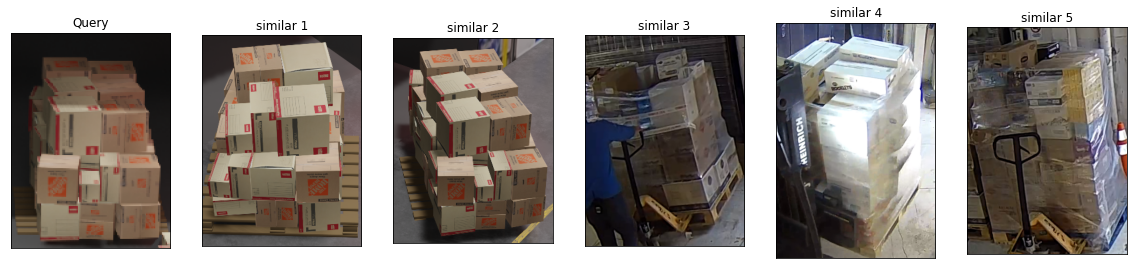

In [14]:
import matplotlib.pyplot as plt
import cv2

img_locs = "/content/MyDrive/MyDrive/SPOT/package_similarities/bultos_cd_74/cd-recorte-6-sint.png"
img = Image.open(img_locs).convert("RGB")
similars = compute_similar_images(img,5,numpy_embedding.reshape((num_images, -1)),"cuda")
print(similars)
img_query = cv2.imread(img_locs)
plt.figure(figsize=(20,25))

img_store = sorted(os.listdir(IMG_SIM_PATH))
plt.subplot(1,6,1)
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.title("Query")
plt.imshow(img_query[:,:,[2,1,0]])
for i,s in enumerate(similars[0]):
  plt.subplot(1,6,i+2)
  plt.title(f"similar {i+1}")
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  img_n = cv2.imread(IMG_SIM_PATH + img_store[s-1])
  plt.imshow(img_n[:,:,[2,1,0]])
plt.show()
